# Telecom customer churn prediction (LR,Random Forest)


## Author: Yuanying Li

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from pylab import rcParams
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import requests
import io
import scipy
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import datetime
from datetime import date
from dateutil.parser import parse
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (21,7)
plt.style.use('seaborn-white')

In [0]:
path='https://docs.google.com/spreadsheets/d/e/2PACX-1vTex43QvaeurapNw1pOaquH_s4VnM78cC2gR5pgPIvkFE3JV48pPEKPFNzaJvwcsee5Y526JIXmhRiW/pub?gid=1933653106&single=true&output=csv'
ts=pd.read_csv(path)

#Dataset Information 



In [0]:
ts.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.00,2,2,1,24,2,2,-1,-1,-2,-2,3913.00,3102.00,689.00,0.00,0.00,0.00,0.00,689.00,0.00,0.00,0.00,0.00,1
1,2,120000.00,2,2,2,26,-1,2,0,0,0,2,2682.00,1725.00,2682.00,3272.00,3455.00,3261.00,0.00,1000.00,1000.00,1000.00,0.00,2000.00,1
2,3,90000.00,2,2,2,34,0,0,0,0,0,0,29239.00,14027.00,13559.00,14331.00,14948.00,15549.00,1518.00,1500.00,1000.00,1000.00,1000.00,5000.00,0
3,4,50000.00,2,2,1,37,0,0,0,0,0,0,46990.00,48233.00,49291.00,28314.00,28959.00,29547.00,2000.00,2019.00,1200.00,1100.00,1069.00,1000.00,0
4,5,50000.00,1,2,1,57,-1,0,-1,0,0,0,8617.00,5670.00,35835.00,20940.00,19146.00,19131.00,2000.00,36681.00,10000.00,9000.00,689.00,679.00,0


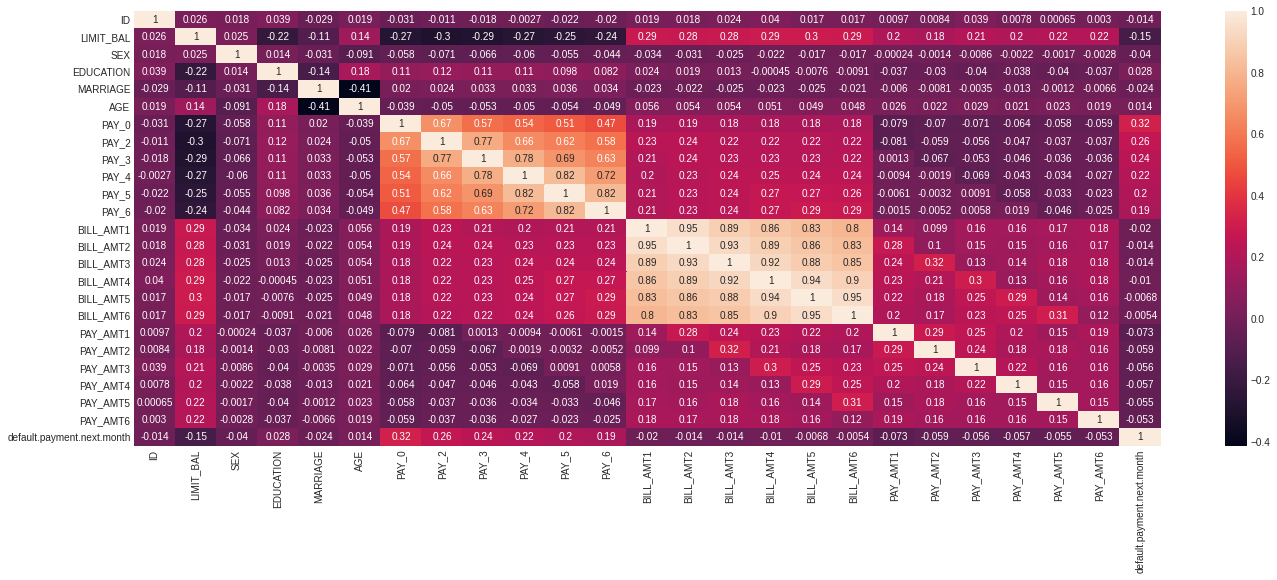

In [0]:
#Plotting correlation heatmap
rcParams['figure.figsize']= (23,8)
sns.heatmap(ts.corr(), annot= True, annot_kws= {'size':10})

In [0]:
ts=ts.dropna()

In [0]:
ts.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,15000.50,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,-0.29,51223.33,49179.08,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50,0.22
std,8660.40,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,1.15,73635.86,71173.77,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47,0.42
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-165580.00,-69777.00,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7500.75,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,3558.75,2984.75,2666.25,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75,0.00
50%,15000.50,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,22381.50,21200.00,20088.50,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00,0.00
75%,22500.25,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,0.00,67091.00,64006.25,60164.75,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00,0.00
max,30000.00,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,8.00,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00,1.00


In [0]:
#Use greater than 3rd quartile+1.5IQR or smaller 1st quartile-1.5IQR represent outliers. 
#Take a serie that needs to get rid of outliers
#Return the boolean condition for loc in order to drop undesired rows for data frame 
#We do not store outliers for this study because to analyze general trends is my focus
def outlier_loc_condition(series):
  oneAndHalfIqr=1.5*(series.quantile(.75)-series.quantile(.25))
  starting_percentile = series.quantile(0.25)-oneAndHalfIqr
  ending_percentile = series.quantile(.75)+oneAndHalfIqr
  return ((series >= starting_percentile) & (series <= ending_percentile))

In [0]:
#Take the dataframe
#Return the dataframe with no outlier
def df_noout(df):
  return df.loc[(outlier_loc_condition(df['BILL_AMT1']))&(outlier_loc_condition(df['LIMIT_BAL']))&(outlier_loc_condition(df['AGE']))&(outlier_loc_condition(df['BILL_AMT2']))&(outlier_loc_condition(df['BILL_AMT3']))&(outlier_loc_condition(df['BILL_AMT4']))&(outlier_loc_condition(df['BILL_AMT5']))&(outlier_loc_condition(df['BILL_AMT6']))&(outlier_loc_condition(df['PAY_AMT1']))&(outlier_loc_condition(df['PAY_AMT2']))&(outlier_loc_condition(df['PAY_AMT3']))&(outlier_loc_condition(df['PAY_AMT4']))&(outlier_loc_condition(df['PAY_AMT5']))&(outlier_loc_condition(df['PAY_AMT6']))]

In [0]:
ts1=df_noout(ts)

In [0]:
ts1.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00,19548.00
mean,14869.43,130405.77,1.60,1.89,1.56,35.01,0.08,-0.05,-0.09,-0.17,-0.23,-0.27,30735.40,28999.42,27073.70,24537.42,22530.85,21568.91,2110.48,1997.70,1690.56,1466.66,1475.22,1440.80,0.26
std,8644.71,108393.34,0.49,0.77,0.52,9.13,1.16,1.27,1.28,1.27,1.24,1.25,34310.31,32970.22,31212.44,28926.94,27441.65,27145.96,2037.21,1995.65,1851.60,1670.53,1695.25,1711.15,0.44
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-11545.00,-18618.00,-15000.00,-15588.00,-20254.00,-24920.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7392.75,50000.00,1.00,1.00,1.00,27.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2400.00,1685.75,1251.00,969.75,709.50,433.50,355.75,291.00,4.75,0.00,0.00,0.00,0.00
50%,14874.50,100000.00,2.00,2.00,2.00,33.00,0.00,0.00,0.00,0.00,0.00,0.00,18230.00,17363.00,16604.00,14870.00,12595.00,10234.00,1740.00,1600.00,1215.00,1000.00,1000.00,1000.00,0.00
75%,22183.25,200000.00,2.00,2.00,2.00,41.00,1.00,0.00,0.00,0.00,0.00,0.00,48677.50,47548.00,44554.25,38055.75,32110.75,30441.25,3000.00,3000.00,2468.25,2086.00,2090.25,2015.25,1.00
max,30000.00,520000.00,2.00,6.00,3.00,60.00,8.00,8.00,8.00,8.00,8.00,8.00,162241.00,155282.00,145978.00,132677.00,122830.00,120940.00,11009.00,11242.00,10661.00,9567.00,9700.00,9817.00,1.00


#Observations
1. There are categorical variables and numberical variables.

2. We observed there are some outliers.

3. Getting rid of outliers might make any classiers perform better.
After removing outliers, we found that about 10,000 rows are dropped. 


In [0]:
#Drop ID column
ts1.drop(columns='ID',inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
ts1

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.00,2,2,1,24,2,2,-1,-1,-2,-2,3913.00,3102.00,689.00,0.00,0.00,0.00,0.00,689.00,0.00,0.00,0.00,0.00,1
1,120000.00,2,2,2,26,-1,2,0,0,0,2,2682.00,1725.00,2682.00,3272.00,3455.00,3261.00,0.00,1000.00,1000.00,1000.00,0.00,2000.00,1
2,90000.00,2,2,2,34,0,0,0,0,0,0,29239.00,14027.00,13559.00,14331.00,14948.00,15549.00,1518.00,1500.00,1000.00,1000.00,1000.00,5000.00,0
3,50000.00,2,2,1,37,0,0,0,0,0,0,46990.00,48233.00,49291.00,28314.00,28959.00,29547.00,2000.00,2019.00,1200.00,1100.00,1069.00,1000.00,0
5,50000.00,1,1,2,37,0,0,0,0,0,0,64400.00,57069.00,57608.00,19394.00,19619.00,20024.00,2500.00,1815.00,657.00,1000.00,1000.00,800.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,210000.00,1,2,1,34,3,2,2,2,2,2,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,0.00,0.00,0.00,0.00,0.00,0.00,1
29992,10000.00,1,3,1,43,0,0,0,-2,-2,-2,8802.00,10400.00,0.00,0.00,0.00,0.00,2000.00,0.00,0.00,0.00,0.00,0.00,0
29994,80000.00,1,2,2,34,2,2,2,2,2,2,72557.00,77708.00,79384.00,77519.00,82607.00,81158.00,7000.00,3500.00,0.00,7000.00,0.00,4000.00,1
29996,150000.00,1,3,2,43,-1,-1,-1,-1,0,0,1683.00,1828.00,3502.00,8979.00,5190.00,0.00,1837.00,3526.00,8998.00,129.00,0.00,0.00,0


In [0]:
#Defining X and y variables
X = ts1.iloc[:, 0:23]
y = ts1.iloc[:, 23:24]

In [0]:
#Training and Testing dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

In [0]:
#Make the grid:
#n_estimators:The number of trees in the forest.
#max_features:The number of features to consider when looking for the best split
#criterion:The function to measure the quality of a split. 
n_estimators=[5,10,50,100,150,200,250]
max_features=[1,5,10,15,23]
criterion=['gini','entropy']

In [0]:
#Loop function for selecting best RF classifiers 

#The general idea is to create a nested for loop after setting varibles to store values.
#Those values aim to find the best and the second best model based on accuracy
#We make oob_score True which means to use out-of-bag samples to estimate the generalization accuracy.
#We make n_jobs -1 to use all processors to make it faster

#The method can take a long time. Be patient. Thanks XD


best1=0.1
best2=0.01

twoa=0
twob=0
twoc=str
onea=0
oneb=0
onec=str

for a in n_estimators:
  for b in max_features:
    for c in criterion:
      clf = RandomForestClassifier(n_estimators=a,max_features=b,criterion=c,oob_score=True,n_jobs=-1,random_state=0)
      clf.fit(X_train, y_train)
      y_pred=clf.predict(X_test)
      score=accuracy_score(y_test,y_pred)    
        
      if (score>best2) & (score<best1):
        best2=score
        twoa=a
        twob=b
        twoc=c
        
      elif score>best1:
        best1=score
        onea=a
        oneb=b
        onec=c
        

print('best2nd model',twoa,twob,twoc,best2)
print('best1st model',onea,oneb,onec,best1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/sklearn/ensembl

best2nd model 150 10 entropy 0.7886582870505701
best1st model 150 5 entropy 0.7888044431452792


In [0]:
# 1st best RF classifier 
clf1 = RandomForestClassifier(n_estimators=150,max_features=5,criterion='entropy',oob_score=True,n_jobs=-1,random_state=0)
clf1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
## 2nd best RF classifier
clf2 = RandomForestClassifier(n_estimators=150,max_features=10,criterion='entropy',oob_score=True,n_jobs=-1,random_state=0)
clf2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

#Logistic Regression (liblinear)

In [0]:
classifier3 = LogisticRegression(solver = 'liblinear',max_iter=1000, random_state= 0)
classifier3.fit( X_train, y_train )
y_pred = classifier3.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for LogReg = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresLR = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean LogReg CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresLR.mean(), scoresLR.std() ))

#Borrowed from: https://colab.research.google.com/drive/16pK0R9LIkvOt9Dk3pvsvZ9W1gARevU-_?authuser=1#scrollTo=b3x7saJewog8 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on Test Set for LogReg = 0.73


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Mean LogReg CrossVal Accuracy on Train Set 0.75, with std=0.00


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#Decision Tree Classifier (entropy)

In [0]:
classifier4 = DecisionTreeClassifier(criterion='entropy', random_state= 0)
classifier4.fit( X_train, y_train )
y_pred3 = classifier4.predict( X_test )

cm1 = confusion_matrix( y_test, y_pred3 )
print("Accuracy on Test Set for Decision Tree (entropy) = %.2f" % ((cm1[0,0] + cm1[1,1] )/len(X_test)))
scoresDT3 = cross_val_score( classifier4, X_train, y_train, cv=2)
print("Mean Decision Tree (entropy) CrossVal Train Set Accuracy Mean: %.2f and Standard Deviation: %.2f \n" % (scoresDT3.mean(), scoresDT3.std() ))

Accuracy on Test Set for Decision Tree (entropy) = 0.70
Mean Decision Tree (entropy) CrossVal Train Set Accuracy Mean: 0.70 and Standard Deviation: 0.00 



Since the accuaracy score of logistic regression is higher than the decision tree classifier, we choose the logistic regression classifier to do the further prediction.

#Printing all model values together 

In [0]:
#RF classifiers 
print('Accuracy for RF 1st best model',best1)
print('Accuracy for RF 2nd best model',best2)

#Logistic Regression (liblinear)
print("Accuracy on Test Set for LogReg = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))

#Decision Tree Classifier (entropy)
print("Accuracy on Test Set for Decision Tree (entropy) = %.2f" % ((cm1[0,0] + cm1[1,1] )/len(X_test)))

Accuracy for RF 1st best model 0.7888044431452792
Accuracy for RF 2nd best model 0.7886582870505701
Accuracy on Test Set for LogReg = 0.73
Accuracy on Test Set for Decision Tree (entropy) = 0.70


We are using accuracy as performance criteria. 
Here we can see, RF classifiers performance are better. 
So we selected two RF classifiers and Logistic Regression classifier as our top three models. 

The parameter configuration:





RF 1st best model: n_estimators=150,max_features=5,criterion='entropy',oob_score=True,n_jobs=-1,random_state=0. 

Rf 2nd best model: n_estimators=150,max_features=10,criterion='entropy',oob_score=True,n_jobs=-1,random_state=0

LogReg: solver = 'liblinear',max_iter=1000, random_state= 0

In [0]:
#Defining arbitary values
arbitrary_values = pd.DataFrame(data = {'LIMIT_BAL':[15300,59766,291003,335000,860020], 'SEX':[2,2,1,1,2],	'EDUCATION':[3,5,1,4,2], 'MARRIAGE':[2,0,3,1,2], 'AGE':[24,59,34,66,70], 'PAY_0':[2,5,4,7,6],	'PAY_2':[0,5,3,4,6], 'PAY_3':[-1,5,7,8,1],	'PAY_4':[8,8,5,5,1,],	'PAY_5':[-1,-1,5,6,6],	'PAY_6':[8,8,4,6,6],	'BILL_AMT1':[22648,-1564,99999,52111,33114],	'BILL_AMT2':[562,7789,-264,-597,900000], 'BILL_AMT3':[456,8996,33333,-44998,792222],	'BILL_AMT4':[-1236,-4566,-7895,65529,10],	'BILL_AMT5':[4561,2222,5555559,35422,0],	'BILL_AMT6':[10,256,99975,-123,555],	'PAY_AMT1':[456,7892,10,56,88888],	'PAY_AMT2':[4,8566,2,699,63333],	'PAY_AMT3':[459,100,23333,56684,336],	'PAY_AMT4':[41,2396,333,66997,44],	'PAY_AMT5':[152,6544,33555,330,12],	'PAY_AMT6':[10,266666,364,19,20]})
arbitrary_values

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,15300,2,3,2,24,2,0,-1,8,-1,8,22648,562,456,-1236,4561,10,456,4,459,41,152,10
1,59766,2,5,0,59,5,5,5,8,-1,8,-1564,7789,8996,-4566,2222,256,7892,8566,100,2396,6544,266666
2,291003,1,1,3,34,4,3,7,5,5,4,99999,-264,33333,-7895,5555559,99975,10,2,23333,333,33555,364
3,335000,1,4,1,66,7,4,8,5,6,6,52111,-597,-44998,65529,35422,-123,56,699,56684,66997,330,19
4,860020,2,2,2,70,6,6,1,1,6,6,33114,900000,792222,10,0,555,88888,63333,336,44,12,20


#Prediction using top three models

In [0]:
#Prediction using 1st best RF classifier 
pd.DataFrame(clf1.predict(arbitrary_values), columns = {'Prediction'})

,Prediction
0,0
1,0
2,0
3,0
4,0


In [0]:
#Prediction using 2nd best RF classifier 
pd.DataFrame(clf2.predict(arbitrary_values), columns = {'Prediction'})


,Prediction
0,1
1,1
2,1
3,0
4,0


In [0]:
#Prediction using Logistic Regression classifier 
pd.DataFrame(classifier3.predict(arbitrary_values), columns = {'Prediction'})

,Prediction
0,0
1,0
2,0
3,0
4,0


The first and the third model gives us the same prediction. However, the second model gives a very different prediction. We might not want to use the second model which is the 2nd best RF.

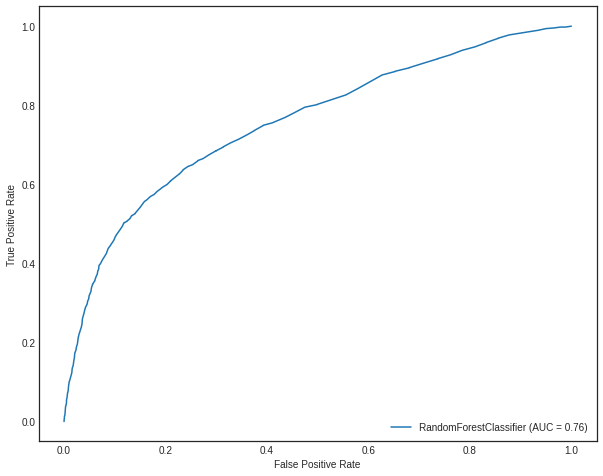

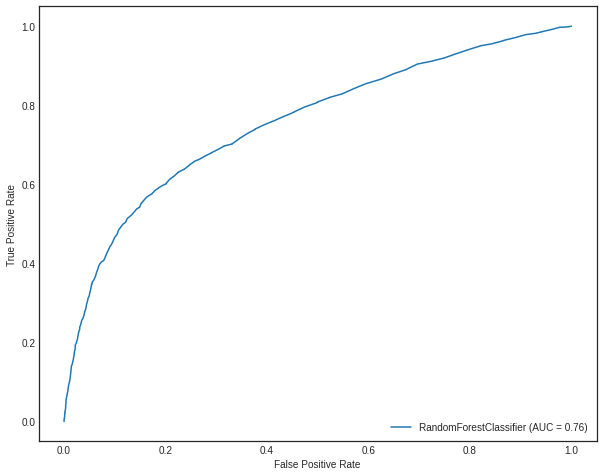

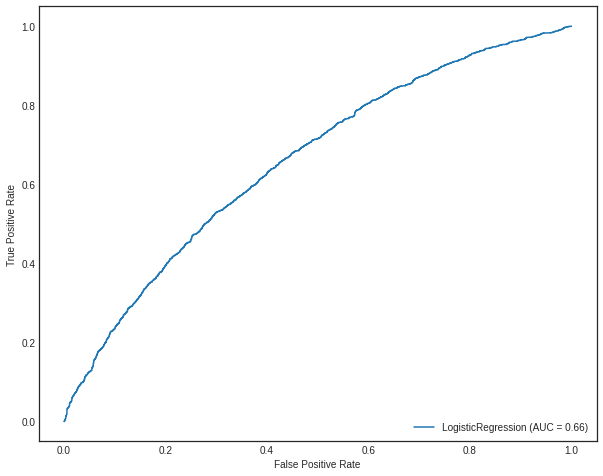

In [0]:
#Plotting all ROC curves together 
rcParams['figure.figsize']= (10,8)
plot_roc_curve(clf1, X_test, y_test)
plot_roc_curve(clf2, X_test, y_test)
plot_roc_curve(classifier3, X_test, y_test)

The 1st best RF has the greatest AUC. This is also a good indication for using it.